# LOYALTY IN SOFTWARE REPOSITORIES OF GITHUB 

## Introduction

This notebook gives an overview of the project describing the techniques and the datasets used to
replicate the data preparation for the analysis carried out by the research paper – Loyalty in Online
Communities [1]. Further I will explain how the data is prepared for the analysis, for each section of the
research paper and will include a test run of the scalable analysis using the above prepared data. This was carried for the course MIE1512 Data Analytics at University of Toronto

## Project Overview

The goal of the project is to find loyalty in software repositories on GitHub by replicating the analysis
carried on the research paper Loyalty in Online Communities. In the research paper the study was
conducted on Reddit and loyalty within subreddits, but I will carry the same study in GitHub and
repositories.
The paper carries out two major analysis – user-user interaction networks and prediction of whether a
user will be loyal to a community based on their first comments. In order to replicate the analysis, I will
be creating many features and datasets from the database which are expanded on in the next sections
of the document. 

## Data Understanding

The data I will use will be obtained from Google BigQuery [2], namely from ‘github_repos’ found in
‘bigquery-public-data’. The database consists of 2.9M public open source licensed repositories on
GitHub. It consists of data about each commit to those repositories from Mar 2016 – March 2019.
Additionally, it also consists of contents, files, languages of the repository and the licenses. Since I do not
require the whole database for my analysis, additionally it is computationally and time inefficient to use
the whole database, I will be creating a dataset to be used as my main dataset for the analysis. To do so,
the data is thoroughly explored first to find the features needed to replicate the analysis. The
exploration was carried within Google BigQuery using SQL queries on ‘sample commits’ which are a
subset of all the commits data in order to save time and the limited amount of query data we have (1TB
per month). The data quality was also kept in mind while collecting the data. Since Google and GitHub
are reputable sources, no additional check was carried to check the data quality, but missing data will be
dealt with in future sections of the document.

## Data Preparation

All the subsequent data preparations were in accordance to the sections of the research paper. The data
was prepared using PySpark SQL and Python code which can be accessed on the attached notebook
under the same section headings as this document. All the data preparation was carried out in a way
that it is scalable and can be replicated easily. The following sections will describe data preparation and
assumptions due to different data sources for all stages of the research paper.

### Main Dataset Creation and Cleaning

As mentioned before a dataset was created from the database which consists of all the features needed
to create feature to conduct our analysis. Two BigQueries was made on Google BigQuery in order to
make two datasets/tables which were later joined in PySpark. After exploring the dataset and studying
the research paper, features needed to for the dataset and the SQL BigQuery used to retrieve the data
are as follows:<br><br>
Table 1:<br>
• Developer/Committer Name – Username of the committer committing to the repository<br>
• Repository Committed – Name of the repository committed to<br>
• Commit Time – Time at which the commit was made<br>
• Watch Count – Watch count of the repositories committed to<br>

BigQuery 1: <br>

SELECT *<br>
FROM<br>
( SELECT committer.name as dev, committer.time_sec as time, reponame as name<br>
FROM bigquery-public-data.github_repos.commits, UNNEST(repo_name) as reponame<br>
GROUP BY dev,time,name<br>
) t1<br>
JOIN<br>
(<br>
SELECT repo_name as name_sr, watch_count<br>
FROM bigquery-public-data.github_repos.sample_repos<br>
ORDER BY watch_count DESC<br>
LIMIT 10000<br>
) t2<br>
ON t1.name = t2.name_sr<br>


Table 2:<br>
• Repository – All the repositories under consideration<br>
• Watch Count – Watch count of the repositories<br>
• Language – The programming language used in the repository<br>

BigQuery 2: <br>
SELECT repo_name as name_l, lang.name as pro_lang<br>
FROM bigquery-public-data.github_repos.languages, UNNEST(language) as lang<br>

Since watch count is a dynamic number, the watch count in Google BigQuery reflects the number of
watchers on the repositories in the Jan-May2016. Although not ideal, this was an important feature as
Google BigQuery has a limit on the amount of free query data that can be retrieved (1TB) and stored
(1GB on Google Drive) not all repositories and commits were considered. To make a fair criterion, only
repositories which were in top 10,000 repositories by descending order of watch count were selected as seen below

In [1]:
#Importing Libraries

import os
os.environ["HADOOP_HOME"] = "S:/Courses/MIE1512/Material/Spark/winutils/"
os.environ["JAVA_HOME"] = "C:/progra~2/Java/jdk1.8.0_221/"
os.environ["JRE_HOME"] = "C:/progra~2/Java/jdk1.8.0_221/jre/"

import findspark
findspark.init("S:/Courses/MIE1512/Material/Spark/spark-2.3.2-bin-hadoop2.7/")

import pyspark
sc = pyspark.SparkContext(appName="myAppName")
spark = pyspark.sql.SQLContext(sc)

import pyspark.sql.types as T 
import pyspark.sql.functions as F
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline 

import networkx as nx

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

import pandas as pd

In [2]:
## Files can be downloaded from the following links:
Table1_url = 'https://drive.google.com/uc?export=download&id=1aJCAsrixii14ydvuG6Ogl2Xvn2NGyiGR'
Table2_url = 'https://drive.google.com/uc?export=download&id=1PKgg3CvrKYZwUeaupNjoQStsZ_lwWOje'
# Please download from the link if needed, as the files are large - 700MB and 200MB
#Copy and paste the file link above and move the downloaded files to the same folder as this jupyter notebook

In [3]:
table1 = spark.read.csv("Table1.csv",
                           header=True,
                           inferSchema=True,
                       )

In [4]:
table1.printSchema()

root
 |-- dev: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- name_sr: string (nullable = true)
 |-- watch_count: integer (nullable = true)



In [5]:
table2 = spark.read.csv("Table2.csv",
                           header=True,
                           inferSchema=True,
                       )

In [6]:
table2.printSchema()

root
 |-- name_l: string (nullable = true)
 |-- pro_lang: string (nullable = true)



In [7]:
table1.registerTempTable("table1")
table2.registerTempTable("table2")

In [8]:
#joining both tables
df = spark.sql("""
SELECT dev, CAST(time as TIMESTAMP), name, watch_count, pro_lang
FROM table1
JOIN table2 ON table1.name = table2.name_l
""")
df.registerTempTable("df")

In [9]:
#dropping na values
df.na.drop()

DataFrame[dev: string, time: timestamp, name: string, watch_count: int, pro_lang: string]

In [11]:
df.limit(5).toPandas()

,dev,time,name,watch_count,pro_lang
0,AigeStudio's Mac,2016-07-03 04:18:15,AigeStudio/WheelPicker,249,Java
1,GitHub,2016-07-12 20:59:32,AigeStudio/WheelPicker,249,Java
2,AigeStudio,2016-07-08 06:14:04,AigeStudio/WheelPicker,249,Java
3,GitHub,2016-07-11 23:28:43,AigeStudio/WheelPicker,249,Java
4,GitHub,2019-06-13 03:05:19,AigeStudio/WheelPicker,249,Java


In [19]:
#calculating number of commits 
spark.sql("""
SELECT COUNT(*) as number_of_commits
FROM df
""").show()

+-----------------+
|number_of_commits|
+-----------------+
|        106910088|
+-----------------+



In [20]:
#calculating number of devs
spark.sql("""
SELECT COUNT(DISTINCT(dev)) as number_of_devs
FROM df
""").show()

+--------------+
|number_of_devs|
+--------------+
|        195253|
+--------------+



In [23]:
#calculating number of repos
spark.sql("""
SELECT COUNT(DISTINCT(name)) as number_of_repos
FROM df
""").show()

+---------------+
|number_of_repos|
+---------------+
|           5822|
+---------------+



df is the main dataset I will be using throughout the project. It consists of developer name, time of commit, name of repository commited to, watch count of that repository and the programming language used. Additionally our data set consists of 106,910,088 rows, that is total number of commits being used for the project. It has 195,253 unique developers and 5,822 unique repositories. I will be using the entire dataset for the project and will not be sampling the data since I want to retain maximum information provided by our dataset

### Operationalizing Loyalty 

The first two sections of the research paper introduce the paper and present related work. The third
section of the paper operationalizes loyalty. In section 3.1 the paper defines loyalty as preference and
commitment towards a community and loyal user sustains preference and commitment to a community
over time. Section 3.2 defines loyalty on Reddit based on commenting behaviour. <br>
The research paper defines loyalty as a preference and commitment towards a community and a loyal user as a user that sustains that preference and commitment towards a community over time. Loyalty on Reddit was a direct extension of a users’ commenting behaviour. In my research loyalty is defined through committing behaviour. A loyal developer is defined as a developer X that commits to a repository A in month t if 100% of his commits that X made are to A in order to show reference. Similarly, an unloyal or a vagrant developer is developer whose commit percentage was not 100% for a month. A commit percentage of 100% was chosen as opposed to 50% comments in the paper because as seen below in the histogram, the stark difference between all commits per month for one repository vs less than 100% commit to one repository.<br>
Additionally, the research paper defines loyal user as a user who stay loyal to a subreddit at time ‘t’ and
‘t+1’. This was not used in my research since most developers work towards a repository only for a few
months or even less.

In [10]:
#calculating number of commits per month towards a repo by each dev
#Adding percentage of commits to a certain repo by each dev and
loyal = spark.sql("""
SELECT dev, YEAR(time) as year, MONTH(time) as month, name, COUNT(*) as num_commits, COUNT(*)*100.0/SUM(COUNT(*)) OVER(partition by MONTH(time),YEAR(time),dev) as percentage_commits
FROM df
GROUP BY dev, name, year, month
ORDER BY dev DESC
""")
loyal.registerTempTable("loyal")

In [46]:
percentage_commit_histogram = spark.sql("""
SELECT CEIL(percentage_commits/5) as bins, COUNT(*) as count
FROM loyal
GROUP BY bins
ORDER BY bins
""").toPandas()

In [47]:
percentage_commit_range = ['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-45','45-50',
                          '50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100']

percentage_commit_histogram['percentage_commit_range'] = percentage_commit_range

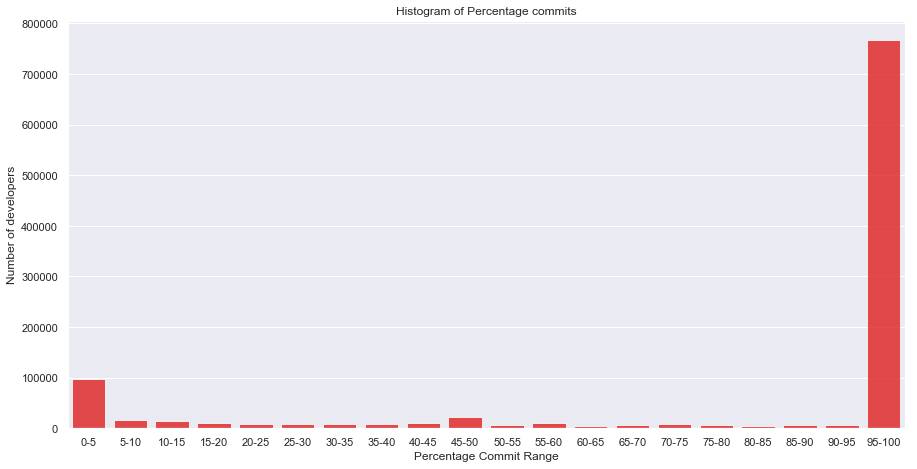

In [49]:
plt.figure(figsize = (15,7.5))
sns.barplot(x='percentage_commit_range',y='count',data=percentage_commit_histogram,color='red',alpha=0.8)
plt.title('Histogram of Percentage commits')
plt.ylabel('Number of developers')
plt.xlabel('Percentage Commit Range')
plt.show()

In [11]:
#Labelling developers loyal if all the commits were to one repo for each month
loyal = loyal.withColumn(
    'loyalty',
    F.when((F.col("percentage_commits") == 100) & (F.col("num_commits") > 3), 'loyal')\
    .when((F.col('percentage_commits') < 100),'vagrant')\
    .when((F.col('percentage_commits') == 100) & (F.col('num_commits') <= 3),'vagrant')
)

In [12]:
loyal.registerTempTable("loyal")

In [16]:
loyal.limit(5).toPandas()

,dev,year,month,name,num_commits,percentage_commits,loyalty
0,🦊Tomoya Hirano,2019,3,apple/swift-corelibs-foundation,27,100.00000000000000,loyal
1,💩,2015,4,hashicorp/vault,9,100.00000000000000,loyal
2,👨🏼‍💻 Romain Marcadier-Muller,2019,1,Microsoft/vscode,33,100.00000000000000,loyal
3,🐈,2019,2,bhilburn/powerlevel9k,3,100.00000000000000,vagrant
4,ＪＯＨＮ ＶＵ,2014,4,cocos2d/cocos2d-objc,25,100.00000000000000,loyal


The study then restricted its analysis to subreddits with at least 25 loyal and 25 vagrant user per month. To take a similar approach for my analysis, I computed the mean number of loyal and vagrant users as which came to about 2.69 loyal developers and 1.6 vagrant developers, the repositories that I used for my analysis had at least 3 loyal developers and at least 1 vagrant developer as that yielded me the similar number of repositories as the number of subreddits considered in the research which is about 2836 repositories in my case. Additionally, due to the nature of GitHub vs Reddit, there were much higher number of loyal developers than vagrant developers whereas in the study there were much higher number of vagrant users.

In [17]:
#Average number of loyal and vagrant devs
spark.sql("""
SELECT AVG(loyal_devs), AVG(vagrant_devs)
FROM
(
SELECT name, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END) loyal_devs,
COUNT(CASE WHEN loyalty = "vagrant" THEN 1 END) vagrant_devs
FROM loyal
GROUP BY name, year, month
)
""").show()

+------------------+------------------+
|   avg(loyal_devs)| avg(vagrant_devs)|
+------------------+------------------+
|2.6868544796304774|1.6054263243310725|
+------------------+------------------+



In [13]:
#Getting repos where loyal devs are greater than 3 and vagrant are more than 1 for our analysis
repos = spark.sql("""
SELECT DISTINCT(name)
FROM
(
SELECT *
FROM
(
SELECT * 
FROM
(
SELECT name, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END) loyal_devs,
COUNT(CASE WHEN loyalty = "vagrant" THEN 1 END) vagrant_devs
FROM loyal
GROUP BY name, year, month
)
WHERE loyal_devs >= 3
)
WHERE vagrant_devs >= 1
)
""")
repos.registerTempTable("repos")

In [79]:
#Number of distinct repos in consideration
spark.sql("""
SELECT count(distinct(name)) as no_repos
FROM repos
""").show()

+--------+
|no_repos|
+--------+
|    2836|
+--------+



In [14]:
#Getting only repos that meet the above criterion
loyal_new = spark.sql("""
SELECT dev,year,month,name as repo_name,num_commits,percentage_commits, loyalty
FROM loyal
WHERE name IN
( SELECT * FROM repos)
ORDER BY dev DESC
""")
loyal_new.registerTempTable("loyal_new")

Further, loyal community is defined in the paper as a community that retains loyal users’ month after
month. The study analyzes all communities with at least 25 loyal users which results in 1440
communities and order the commmunities based on loyalty rate for each community which is defined as proportion of users who prefer community A at time t and sustain the preference at time t+1. Loyal communities are then denotes as top 25% of the distribution and un loyal communities as bottom 25% of the distribution.<br>
For my research project,as seen above, I end up with 2836 repositories. In order to find loyal and unloyal repos, I first find the loyalty rate of the repositories. We can see below that loyalty rate for repositories can be zero since repositories don't necessarily have commit each month which can lead to innacurate assumption of whether a repository is loyal or not. Therefore loyalty rate is ommited from my project and inplace I will use loyalty to vagrant ratio for each repo.<br>
I calculate average loyal to vagrant ratio for each repo and then I pick the top 25% of those repos as loyal repos and the bottom 25% as unloyal repos.

In [18]:
#Adding loyalty rate for each repo
spark.sql("""


SELECT repo_name, AVG(loyalty_rate) as avg_loyalty_rate
FROM
(
SELECT t1.repo_name, t1.year, t1.month, ROUND(((t2.loyal_devs-t1.loyal_devs)/t1.loyal_devs)*100,2)  as loyalty_rate
FROM
(
SELECT repo_name, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END) loyal_devs,
COUNT(CASE WHEN loyalty = "vagrant" THEN 1 END) vagrant_devs
FROM loyal_new
GROUP BY repo_name, year, month
)t1
INNER JOIN
(
SELECT repo_name, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END) loyal_devs,
COUNT(CASE WHEN loyalty = "vagrant" THEN 1 END) vagrant_devs
FROM loyal_new
GROUP BY repo_name, year, month
)t2
ON t1.repo_name = t2.repo_name 
AND t1.month + 1 = t2.month
)
GROUP BY repo_name

""").show()

+--------------------+-------------------+
|           repo_name|   avg_loyalty_rate|
+--------------------+-------------------+
|   dgibbs64/linuxgsm| 27.507591743119264|
|      hashicorp/serf| -20.34913333333333|
|   reactjs/React.NET| 0.4596206896551723|
|fantasyland/fanta...|           -47.5575|
|      mozilla/tofino|  64.09181818181818|
|   QuantConnect/Lean| 16.406258278145696|
|atomicobject/obje...|-10.305496183206106|
|        randym/axlsx| -36.27197368421053|
|       Gazler/githug|   77.3741791044776|
|shwenzhang/AndRes...|  9.081338582677164|
|   jenkinsci/jenkins|   42.9129552390641|
|     skizzehq/skizze| -4.166666666666667|
|apache/incubator-...|  32.89890829694323|
|dyve/django-boots...|-13.985198019801981|
|     angular/angular|  38.56970588235294|
|        tomaka/glium| -40.65538461538462|
| broccolijs/broccoli|-16.535157894736844|
|aksonov/react-nat...|              -17.5|
| chrisaljoudi/uBlock| -9.880833333333333|
|         needim/noty|         -49.609375|
+----------

In [21]:
#Computing Avg loyalty ratios for each repository

spark.sql("""

SELECT repo_name, AVG(loyalty_ratio) as avg_loyalty_ratio
FROM
(
SELECT repo_name, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*) as loyalty_ratio
FROM loyal_new
GROUP BY repo_name, year, month
)
GROUP BY repo_name

""").show()

+--------------------+-------------------+
|           repo_name|  avg_loyalty_ratio|
+--------------------+-------------------+
|   jenkinsci/jenkins| 0.9309646700110524|
|   dgibbs64/linuxgsm| 0.5753092145949288|
|   QuantConnect/Lean| 0.8231235695521408|
|shwenzhang/AndRes...| 0.8434959349593496|
|atomicobject/obje...| 0.7318518518518518|
|   reactjs/React.NET| 0.5967661691542289|
|fantasyland/fanta...|0.26320754716981126|
|dyve/django-boots...| 0.3822404371584699|
|apache/incubator-...| 0.8581978537335679|
|      hashicorp/serf|0.18569624819624816|
|     skizzehq/skizze|              0.705|
|        randym/axlsx|0.20830853174603178|
|       Gazler/githug| 0.6088815789473685|
|     angular/angular| 0.7446682035557575|
|      mozilla/tofino| 0.8536796536796539|
|           grpc/grpc| 0.8915760340868597|
|    mesonbuild/meson| 0.9016070892491347|
| broccolijs/broccoli| 0.4824712643678161|
|         magit/magit| 0.5721759520672566|
|         needim/noty|0.27736318407960203|
+----------

In [18]:
#Retrieving Top 25% repositories when arranged by avg loyalty ratio as loyal repos
loyal_repos = spark.sql("""
SELECT repo_name as repo_name, avg_loyalty_ratio
FROM
(
SELECT repo_name, avg_loyalty_ratio, NTILE(4) OVER (ORDER BY avg_loyalty_ratio DESC) ntile_ratio
FROM
(
SELECT repo_name, AVG(loyalty_ratio) as avg_loyalty_ratio
FROM
(
SELECT repo_name, year, month,
(COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*)) as loyalty_ratio
FROM loyal_new
GROUP BY repo_name, year, month
)
GROUP BY repo_name
)
)
WHERE ntile_ratio = 1
""")

loyal_repos.registerTempTable('loyal_repos')

In [19]:
#Retrieving Bottom 25% repositories when arranged by avg loyalty ratio as loyal repos
unloyal_repos = spark.sql("""
SELECT repo_name as repo_name, avg_loyalty_ratio
FROM
(
SELECT repo_name, avg_loyalty_ratio, NTILE(4) OVER (ORDER BY avg_loyalty_ratio DESC) ntile_ratio
FROM
(
SELECT repo_name, AVG(loyalty_ratio) as avg_loyalty_ratio
FROM
(
SELECT repo_name, year, month,
(COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*)) as loyalty_ratio
FROM loyal_new
GROUP BY repo_name, year, month
)
GROUP BY repo_name
)
)
WHERE ntile_ratio = 4
""")

unloyal_repos.registerTempTable('unloyal_repos')

In [20]:
spark.sql("""
SELECT COUNT(DISTINCT(repo_name)) as num_repos
FROM loyal_repos
""").show()

+---------+
|num_repos|
+---------+
|      709|
+---------+



### Community Level Loyalty 

In this section, analysis was done on communities i.e., repositories that foster high loyalty as we described using loyalty to vagrant ratio. This analysis aims to answer the question whether certain repositories have structural features that foster loyal users.

#### Basic Features of Loyal Communities 

Firstly, basic features of loyal communities are assessed such as size of the community, growth rate for the community and thread length for the subreddit. In case of this project the size of the repository i.e., average number of developers in the loyal vs un loyal repositories, average loyalty ratios for both and number of commits per month for each repository are compared as well. It was found that average number of developers are 1.6 times more for loyal than unloyal repositories. Additionally, Loyalty ratio is much higher in loyal repositories which is expected since that was the criteria to choose our loyal vs unloyal repositories. Lastly, average number of commits per month for loyal repos seems to be much higher than that of unloyal repos (3.2 times) and thus suggests that it is a strong predictor of a loyal repositories and can be used as a feature to predict loyalty in section 5.3.

In [24]:
#Calculating average number of devs for loyal repos
spark.sql("""
SELECT AVG(number_of_devs) as average_devs_in_loyal_repos
FROM
(
SELECT repo_name, COUNT(DISTINCT(dev)) as number_of_devs
FROM
(
SELECT dev, t1.repo_name as repo_name, year, month, num_commits,percentage_commits, loyalty
FROM loyal_repos t1
JOIN loyal_new t2
ON t1.repo_name = t2.repo_name
)
GROUP BY repo_name
ORDER BY number_of_devs DESC
)
""").show()

+---------------------------+
|average_devs_in_loyal_repos|
+---------------------------+
|         131.86600846262343|
+---------------------------+



In [25]:
#Calculating average number of devs for unloyal repos
spark.sql("""
SELECT AVG(number_of_devs) as average_devs_in_loyal_repos
FROM
(
SELECT repo_name, COUNT(DISTINCT(dev)) as number_of_devs
FROM
(
SELECT dev, t1.repo_name as repo_name, year, month, num_commits,percentage_commits, loyalty
FROM unloyal_repos t1
JOIN loyal_new t2
ON t1.repo_name = t2.repo_name
)
GROUP BY repo_name
ORDER BY number_of_devs DESC
)
""").show()

+---------------------------+
|average_devs_in_loyal_repos|
+---------------------------+
|          82.34132581100141|
+---------------------------+



In [26]:
#Average loyalty ratios for loyal repos
spark.sql("""
SELECT AVG(avg_loyalty_ratio) as average_loyaltyratio_loyalrepos
FROM loyal_repos
""").show()

+-------------------------------+
|average_loyaltyratio_loyalrepos|
+-------------------------------+
|             0.8770550922617407|
+-------------------------------+



In [27]:
#Average loyalty ratios for unloyal repos
spark.sql("""
SELECT AVG(avg_loyalty_ratio) as average_loyaltyratio_unloyalrepos
FROM unloyal_repos
""").show()

+---------------------------------+
|average_loyaltyratio_unloyalrepos|
+---------------------------------+
|              0.24932602949649035|
+---------------------------------+



In [28]:
# average number of commits per month for loyal repos
spark.sql("""

SELECT AVG(num_commits) as average_commits_per_month_loyalrepos
FROM
(
SELECT dev, t1.repo_name as repo_name, year, month, num_commits,percentage_commits, loyalty
FROM loyal_repos t1
JOIN loyal_new t2
ON t1.repo_name = t2.repo_name
)

""").show()

+------------------------------------+
|average_commits_per_month_loyalrepos|
+------------------------------------+
|                   180.4692621051222|
+------------------------------------+



In [29]:
# average number of commits per month for unloyal repos
spark.sql("""

SELECT AVG(num_commits) as average_commits_per_month_unloyalrepos
FROM
(
SELECT dev, t1.repo_name as repo_name, year, month, num_commits,percentage_commits, loyalty
FROM unloyal_repos t1
JOIN loyal_new t2
ON t1.repo_name = t2.repo_name
)

""").show()

+--------------------------------------+
|average_commits_per_month_unloyalrepos|
+--------------------------------------+
|                     56.55770536320434|
+--------------------------------------+



#### Topics of loyal communities

The research paper then looks at the subreddit names for the loyal vs unloyal communities in order to find topics that attract loyal users. For my project I compared the programming languages for the loyal and unloyal repositories and the results can be seen in Figure (iii). It seems that unloyal repositories prefer JavaScript which is often a language user learn to get started in coding and that could mean they commit to projects using JavaScript on GitHub but only few sustain committing to those projects. Additionally, Shell script is a very old language and hence has a loyal user base and thus the repositories in Shell could retain higher number of loyal users.

In [26]:
#Language for loyal repos
prolang_loyal = spark.sql("""
SELECT pro_lang, COUNT(DISTINCT(repo_name)) as num_of_repos_loyal
FROM
(
SELECT name as repo_name, pro_lang
FROM df
WHERE name IN
( SELECT repo_name
FROM loyal_repos
)

)
GROUP BY pro_lang
ORDER BY num_of_repos_loyal DESC
LIMIT 10
""")
prolang_loyal.registerTempTable("prolang_loyal")

In [27]:
#Language for unloyal repos
prolang_unloyal = spark.sql("""
SELECT pro_lang, COUNT(DISTINCT(repo_name)) as num_of_repos_unloyal
FROM
(

SELECT name as repo_name, pro_lang
FROM df
WHERE name IN
( SELECT repo_name
FROM unloyal_repos
)

)
GROUP BY pro_lang
ORDER BY num_of_repos_unloyal DESC
LIMIT 10
""")
prolang_unloyal.registerTempTable('prolang_unloyal')

In [28]:
#Joining both
pro_lang = spark.sql("""
SELECT t1.pro_lang, num_of_repos_loyal,num_of_repos_unloyal
FROM prolang_loyal t1
JOIN prolang_unloyal t2
ON t1.pro_lang = t2.pro_lang
""").toPandas()

In [29]:
pro_lang.head()

,pro_lang,num_of_repos_loyal,num_of_repos_unloyal
0,Shell,538,205
1,HTML,438,213
2,JavaScript,415,308
3,CSS,389,157
4,Python,313,90


In [30]:
pro_lang.columns = ['Programming Language','loyal','unloyal']

In [31]:
pro_lang_2 = pd.melt(pro_lang, id_vars=['Programming Language'], value_vars=['loyal', 'unloyal'])


In [32]:
pro_lang_2.columns = ['Programming Language','Kind of Repo','Number of Repos']

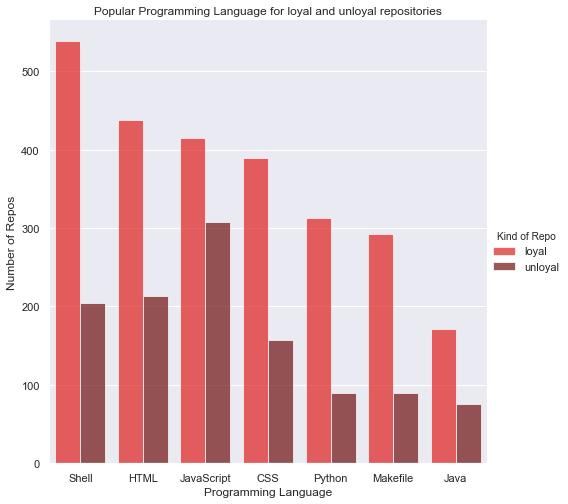

In [45]:
sns.catplot(x='Programming Language', y='Number of Repos', hue='Kind of Repo', data=pro_lang_2, kind='bar',height=7, aspect=1,palette=sns.color_palette(['red', 'maroon']),alpha=0.7)
plt.title('Popular Programming Language for loyal and unloyal repositories')
plt.show()

#### Loyalty in interaction networks 

Finally, in the research paper, for each type on community, monthly interaction networks were constructed where a user is connected if they comment in the same linear comment chain within three comments of each others. The loyal and unloyal networks of a first-person shooter video game were then analysed based on network properties.
For my project I connected developers if they committed to same repository for a particular month since they probably interacted with each other or each other's work during that period, which was the rational behind the connection in the research paper as well.
Next a loyal network and unloyal network was developed based on the average loyalty ratio described in section 3.0 where the loyalty network was formed using the repository that had the highest average loyalty ratio of 0.99 (drupal/drupal) and unloyal network had the lowest of 0.02 (Microsoft/TypeScript). The networks were formed using the NetworkX library in Python and were then visualised as seen in the visualisation below and the density, average clustering and assortativity of the networks were also calculated. The loyal network has higher density than unloyal network suggesting that developers in loyal repositories are more connected to each other. Unloyal network had slightly higher average clustering suggesting that unloyal repositories have many clusters within them while loyal networks have less core clusters. Additionally, not much significant difference between assortativity was observed. The results can be seen in the plots below. <br>

Next, the study also creates a linear mixed model to regress community’s loyalty rate in order to prove that community structure i.e., the networks created above are a good predictor of the loyalty rate. While interesting, it was left out of my project since it is not in the scope of my project because loyalty rate is not used. Additionally, a similar prediction task is carried in section 5.2 of the report using features from section 4.0

In [21]:
#Table with only loyal repos and the corresponding data
loyal_only = spark.sql("""
SELECT dev, t1.repo_name as repo_name, year, month, num_commits,percentage_commits, loyalty
FROM loyal_repos t1
JOIN loyal_new t2
ON t1.repo_name = t2.repo_name
""")
loyal_only.registerTempTable("loyal_only")

In [22]:
#Table with only unloyal repos and the corresponding data
unloyal_only = spark.sql("""
SELECT dev, t1.repo_name as repo_name, year, month, num_commits,percentage_commits, loyalty
FROM unloyal_repos t1
JOIN loyal_new t2
ON t1.repo_name = t2.repo_name
""")
unloyal_only.registerTempTable("unloyal_only")

In [21]:
#Forming interaction graphs table for all loyal repos
loyal_graph = spark.sql("""

SELECT *
FROM
(
SELECT t1.dev as dev1, t2.dev as dev2, t1.name as repo_name
FROM
(
SELECT dev, year, month, name
FROM loyal
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_repos
)
) t1
JOIN
(
SELECT dev, year, month, name
FROM loyal
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_repos
)
) t2
ON t1.name = t2.name AND t1.year = t2.year AND t1.month = t2.month
)
WHERE dev1 <> dev2

""")
loyal_graph.registerTempTable("loyal_graph")

In [22]:
#Creating interaction table for loyal repo with highest loyalty ratio
most_loyal_graph = spark.sql("""
SELECT dev1,dev2
FROM loyal_graph
WHERE repo_name IN
(
SELECT repo_name
FROM loyal_repos
ORDER BY avg_loyalty_ratio DESC
LIMIT 1
)
""")
most_loyal_graph.registerTempTable("most_loyal_graph")

In [48]:
#Repo used for loyal network
spark.sql("""

SELECT *
FROM loyal_repos
ORDER BY avg_loyalty_ratio DESC
LIMIT 1

""").show()

+-------------+-----------------+
|    repo_name|avg_loyalty_ratio|
+-------------+-----------------+
|drupal/drupal| 0.99624662091911|
+-------------+-----------------+



In [49]:
#Forming interaction graphs table for all unloyal repos
unloyal_graph = spark.sql("""
SELECT *
FROM
(
SELECT t1.dev as dev1, t2.dev as dev2, t1.name as repo_name
FROM
(
SELECT dev, year, month, name
FROM loyal
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM unloyal_repos
)
) t1
JOIN
(
SELECT dev, year, month, name
FROM loyal
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM unloyal_repos
)
) t2
ON t1.name = t2.name AND t1.year = t2.year AND t1.month = t2.month
)
WHERE dev1 <> dev2

""")
unloyal_graph.registerTempTable("unloyal_graph")

In [50]:
#Creating interaction table for unloyal repo with lowest loyalty ratio
most_unloyal_graph = spark.sql("""
SELECT dev1,dev2
FROM unloyal_graph
WHERE repo_name IN
(
SELECT repo_name
FROM unloyal_repos
ORDER BY avg_loyalty_ratio ASC
LIMIT 1
)
""")
most_unloyal_graph.registerTempTable("most_unloyal_graph")

In [51]:
#Repo used for unloyal network
spark.sql("""

SELECT *
FROM unloyal_repos
ORDER BY avg_loyalty_ratio ASC
LIMIT 1

""").show()

+--------------------+-------------------+
|           repo_name|  avg_loyalty_ratio|
+--------------------+-------------------+
|Microsoft/TypeScr...|0.02712045264676844|
+--------------------+-------------------+



In [26]:
#Loyal Network
most_loyal_graph = most_loyal_graph.toPandas()

#Unloyal network
most_unloyal_graph = most_unloyal_graph.toPandas()

In [76]:
loyal_g =nx.from_pandas_edgelist(most_loyal_graph, 'dev1', 'dev2')
loyal_network_properties = {}
loyal_network_properties['density']=nx.density(loyal_g)
loyal_network_properties['clustering']=nx.average_clustering(loyal_g)
loyal_network_properties['assortativity']=nx.degree_assortativity_coefficient(loyal_g)
loyal_network_properties['network']='loyal'

loyal_network_properties_df = pd.DataFrame([loyal_network_properties], columns=loyal_network_properties.keys())

In [77]:
unloyal_g =nx.from_pandas_edgelist(most_unloyal_graph, 'dev1', 'dev2')
unloyal_network_properties = {}
unloyal_network_properties['density']=nx.density(unloyal_g)
unloyal_network_properties['clustering']=nx.average_clustering(unloyal_g)
unloyal_network_properties['assortativity']=nx.degree_assortativity_coefficient(unloyal_g)
unloyal_network_properties['network']='unloyal'

unloyal_network_properties_df = pd.DataFrame([unloyal_network_properties], columns=unloyal_network_properties.keys())

In [89]:
network_properties_df = pd.concat([loyal_network_properties_df,unloyal_network_properties_df])
network_properties_df.head()

,density,clustering,assortativity,network
0,0.218045,0.807300,-0.229975,loyal
0,0.054673,0.945688,-0.277113,unloyal


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


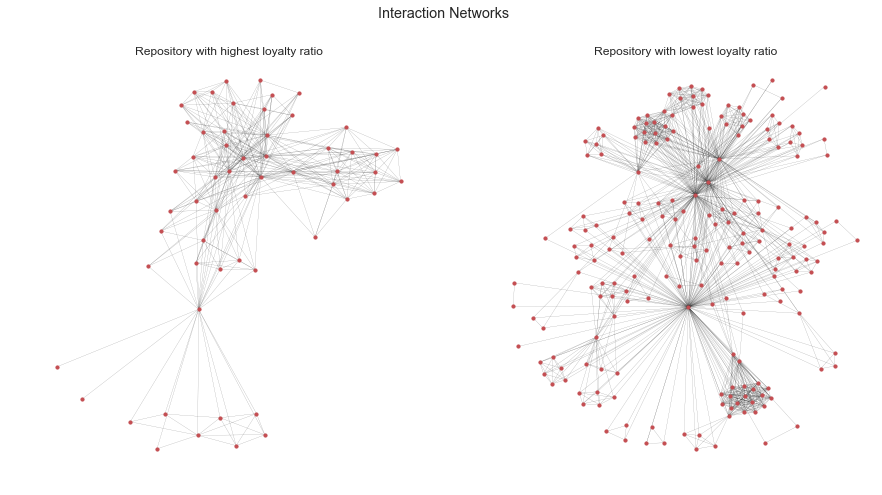

In [138]:
fig, axes = plt.subplots(1,2,figsize=(15,7.5))
ax = axes.flatten()

nx.draw(loyal_g, node_size = 10, width = 0.1,ax=ax[0])
nx.draw(unloyal_g, node_size = 10, width = 0.1, ax=ax[1])
ax[0].set_title('Repository with highest loyalty ratio')
ax[1].set_title('Repository with lowest loyalty ratio')
plt.suptitle("Interaction Networks")
plt.show()


Text(0.51, 1.05, 'Network Properties')

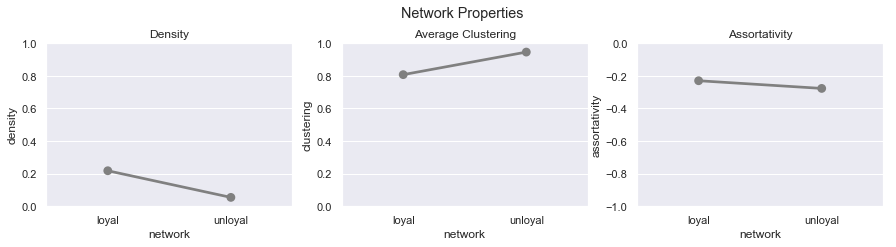

In [141]:
fig, axes = plt.subplots(1,3,figsize=(15,3))
ax = axes.flatten()
sns.pointplot(x="network", y="density", data=network_properties_df,color='grey', ax=ax[0])
ax[0].set_title('Density')
ax[0].set_ylim(0,1)
sns.pointplot(x="network", y="clustering", data=network_properties_df,color='grey', ax=ax[1])
ax[1].set_title('Average Clustering')
ax[1].set_ylim(0,1)
sns.pointplot(x="network", y="assortativity", data=network_properties_df,color='grey',ax=ax[2])
ax[2].set_title('Assortativity')
ax[2].set_ylim(-1,0)
plt.suptitle("Network Properties", y=1.05,x=0.51)

### User-level Loyalty 

In order to asses user level loyalty, 100 random loyal and vagrant users were selected in the study, and analysis was conducted on post selection, linguistic style of comments and a prediction model was also built. For my research I created a feature - 'dev loyalty ratio' which will tell whether a developer has been loyal throughout his committing journey on GitHub if the average ratio is 1, else when ratio is closer to 0 it suggests more vagrant user. It is calculated as the ratio of the months the developer has been loyal to all the months, he/she has been active on GitHub. I pick the top 100 of this distribution ordered by descending order of ratio as loyal developers and bottom 100 as vagrant developers.

In [23]:
# selecting loyal devs
loyal_devs = spark.sql("""
SELECT dev, AVG(dev_loyalty_ratio) as avg_loyalty_ratio
FROM
(
SELECT dev, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*) as dev_loyalty_ratio
FROM loyal_new
GROUP BY dev, year, month
)
GROUP BY dev
ORDER BY avg_loyalty_ratio DESC
LIMIT 100
""")
loyal_devs.registerTempTable("loyal_devs")

In [24]:
# selecting loyal devs
unloyal_devs = spark.sql("""
SELECT dev, AVG(dev_loyalty_ratio) as avg_loyalty_ratio
FROM
(
SELECT dev, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*) as dev_loyalty_ratio
FROM loyal_new
GROUP BY dev, year, month
)
GROUP BY dev
ORDER BY avg_loyalty_ratio ASC
LIMIT 100
""")
unloyal_devs.registerTempTable("unloyal_devs")

#### Post Selection

In the research paper posts that loyal and vagrant users select to comment on are looked at by firstly post popularity. In my project I calculated at the average watch count of repos that loyal and unloyal developers commit to and it was found that loyal developers tend to commit to repositories with higher watch count. <br>
Additionally, the research also looked at the linguistic style of the posts the different users comment on to assess the content preference for loyal and vagrant developers. The linguistic information available on GitHub is mostly commit message and the code itself, which didn’t contribute much to the analysis that was carried and therefore was not included in the project.


In [25]:
#Average watch count for loyal devs
spark.sql("""
SELECT AVG(watch_count) as average_watchcount_for_repos_loyaldevs
from df
WHERE dev IN
(
SELECT dev
FROM loyal_devs
)
""").show()

+--------------------------------------+
|average_watchcount_for_repos_loyaldevs|
+--------------------------------------+
|                     730.4951065054692|
+--------------------------------------+



In [31]:
#Average watch count for unloyal devs
spark.sql("""
SELECT AVG(watch_count) as average_watchcount_for_repos_unloyaldevs
from df
WHERE dev IN
(
SELECT dev
FROM unloyal_devs
)
""").show()

+----------------------------------------+
|average_watchcount_for_repos_unloyaldevs|
+----------------------------------------+
|                      460.03237410071944|
+----------------------------------------+



####  Style of Comments 

Next the linguistic style of comments the loyal and vagrant users' write was also compared.
Although since linguistic style of commit did not provide much information in case of GitHub, in order to understand the ‘commit style’ and to capture the commit patterns, new features were created using research papers that analysed GitHub repositories for other research purposes. [3] Average days between one commit to a repository for a loyal and vagrant developer selected with the same criteria as mentioned in introduction of section 5.0 was calculated. It was found that the loyal developers seem to commit more often that unloyal developers with average days between loyal developers being 5.93 whereas for unloyal developers it was found to be 8.47 days.


In [23]:
#retriving commit time for each commit for loyal devs
loyal_freq = spark.sql("""

SELECT dev, name, time
FROM df
WHERE dev IN
(
SELECT dev
FROM loyal_devs
)
GROUP BY dev, name, time
ORDER BY dev, name, time

""")
loyal_freq.registerTempTable("loyal_freq")

In [32]:
#Average days between commit for each repo for loyal devs
spark.sql("""
SELECT AVG(avg_days_btwn_commit) as avg_days_btwn_commit_loyal
FROM
(
SELECT dev, name,
CASE
    WHEN COUNT(*) < 2 THEN 0
    ELSE DATEDIFF(MAX(time),MIN(time))/(COUNT(*)-1)
END AS avg_days_btwn_commit
FROM loyal_freq
GROUP BY dev, name
)
""").show()

+--------------------------+
|avg_days_btwn_commit_loyal|
+--------------------------+
|         5.931300448820951|
+--------------------------+



In [24]:
#retriving commit time for each commit for unloyal devs
unloyal_freq = spark.sql("""

SELECT dev, name, time
FROM df
WHERE dev IN
(
SELECT dev
FROM unloyal_devs
)
GROUP BY dev, name, time
ORDER BY dev, name, time

""")
unloyal_freq.registerTempTable("unloyal_freq")

In [35]:
#Average days between commit for each repo for unloyal devs
spark.sql("""
SELECT AVG(avg_days_btwn_commit) as avg_days_btwn_commit_unloyal
FROM
(
SELECT dev, name,
CASE
    WHEN COUNT(*) < 2 THEN 0
    ELSE DATEDIFF(MAX(time),MIN(time))/(COUNT(*)-1)
END AS avg_days_btwn_commit
FROM unloyal_freq
GROUP BY dev, name
)
""").show()

+----------------------------+
|avg_days_btwn_commit_unloyal|
+----------------------------+
|           8.475541336924044|
+----------------------------+



#### Predicting loyalty from first contributions


Finally, a prediction task of determining whether a user will become loyal to a community based on the user’s comments to that community is conducted in the research paper. To do so a classifier is trained per community on the initial k=3 comments of users who made their first contributions between January 2014 - June 2014 and predictions are made on users that commented on the community during July 2014 - October 2014. A random forest classifier was used, and features used were post score, post language and comment language.
For my research I carried out a similar prediction task using random forest classifier in PySpark ML library. The features were chosen on a monthly basis. Therefore, the data used was not 4 months for training and predicting like in the research but 1 year since the information available for each developer will not be enough if just 4 months was utilised. The features and the label created and used for the prediction were:<br><br>
• Feature 1 - Number of commits per month for each developer - as seen in section 4.1 is different for loyal and unloyal repositories<br>
• Feature 2 - Average repository loyalty ratio - as seen in section 3.0<br>
• Feature 3 - Watch count of the repository the developer is committing to - as seen in section 5.1<br>
• Feature 4 - Average days between commit for each developer - as seen in section 5.2<br>
• Label - '1' if the developer loyalty ratio is greater than 0.8 and '0' if the loyalty ratio is less than equal to 0.8. This threshold is selected based on average developer loyalty ratio which was found to be 0.8.<br><br>
The model was trained on data for each developer and the corresponding repositories the committed, which can be more than one for each developer, and their corresponding above-mentioned features for year 2017. The predictions were made on 2018 data using the same features. A random forest classifier with 100 trees and a max depth of 10 was used to train. The model was then used to predict if a developer will be loyal or will be vagrant on GitHub defined by the criteria in section 3.0 based on average days between commit, number of commits per month, loyalty ratio for repositories and the repository watch count for the first month of his commits, similar to how the research predicted whether user will be loyal based on initial 3 comments. The model performs yielded 0.9 Area Under ROC in predicting loyalty of a developer. This suggests that the features we calculated and used are a very good predictor of whether a developer will be loyal or not given their earlier commits on GitHub.

In [47]:
# selection criteria for label
spark.sql("""
SELECT AVG(dev_loyalty_ratio) as avg_loyalty_ratio_all_devs
FROM
(
SELECT dev, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*) as dev_loyalty_ratio
FROM loyal_new
GROUP BY dev, year, month
)
""").show()

+--------------------------+
|avg_loyalty_ratio_all_devs|
+--------------------------+
|        0.8013986199399455|
+--------------------------+



In [21]:
#Feature 1 - Number of commits per month for each dev to each repo
train_f1 = spark.sql("""

SELECT dev, name, AVG(number_of_commits) as avg_number_of_commits_permonth
FROM
(
SELECT dev, name, MONTH(time) as month, COUNT(*) as number_of_commits
FROM
(
SELECT dev, name, time, watch_count
FROM df
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_new
)
AND YEAR(time) = 2017
)
GROUP BY dev, name, month
)
GROUP BY dev, name

""")
train_f1.registerTempTable("train_f1")

In [22]:
#Feature 2 - Loyalty ratio of the repos
train_f2 = spark.sql("""

SELECT repo_name, AVG(loyalty_ratio) as avg_loyalty_ratio
FROM
(
SELECT repo_name, year, month,
(COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*)) as loyalty_ratio
FROM loyal_new
GROUP BY repo_name, year, month
HAVING year = 2017

)
GROUP BY repo_name


""")

train_f2.registerTempTable("train_f2")

In [23]:
#Feature 3 - Average Days between commit for each dev
train_f3 = spark.sql("""

SELECT dev, name,
CASE
    WHEN COUNT(*) < 2 THEN 0
    ELSE DATEDIFF(MAX(time),MIN(time))/(COUNT(*)-1)
END AS avg_days_btwn_commit
FROM
(
SELECT dev, name, time, watch_count
FROM df
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_new
)
AND YEAR(time) = 2017
)
GROUP BY dev, name

""")

train_f3.registerTempTable("train_f3")

In [24]:
#Feature 4 - watch count of each repo
train_f4 = spark.sql("""

SELECT dev, name, AVG(watch_count) as avg_watch_count
FROM
(
SELECT dev, name, time, watch_count
FROM df
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_new
)
AND YEAR(time) = 2017
)
GROUP BY dev, name

""")

train_f4.registerTempTable("train_f4")

In [25]:
# Label generation
label = spark.sql("""

SELECT dev,
CASE
    WHEN avg_dev_loyalty_ratio >0.8 THEN 1
    WHEN avg_dev_loyalty_ratio <= 0.8 THEN 0
END AS label
FROM
(
SELECT dev, AVG(dev_loyalty_ratio) as avg_dev_loyalty_ratio
FROM
(
SELECT dev, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*) as dev_loyalty_ratio
FROM loyal_new
GROUP BY dev, year, month
HAVING year =2017
)
GROUP BY dev
)


""")

label.registerTempTable("label")

In [26]:
#Training set 2017

train = spark.sql("""

SELECT train_f1.dev, train_f1.name, avg_days_btwn_commit, avg_loyalty_ratio, avg_number_of_commits_permonth, avg_watch_count, label
FROM train_f1
JOIN train_f3 ON train_f1.dev=train_f3.dev AND train_f1.name = train_f3.name
    JOIN train_f4 ON train_f3.dev=train_f4.dev AND train_f4.name = train_f4.name
        JOIN label ON train_f4.dev=label.dev
            JOIN train_f2 ON train_f1.name = train_f2.repo_name

        
""")
train.registerTempTable("train")

In [39]:
train.limit(10).toPandas()

,dev,name,avg_days_btwn_commit,avg_loyalty_ratio,avg_number_of_commits_permonth,avg_watch_count,label
0,Gary Rennie,Gazler/githug,12.478261,0.25000,6.0,1088.0,unloyal
1,Gary Rennie,Gazler/githug,12.478261,0.25000,6.0,1639.0,unloyal
2,comesx4,QuantConnect/Lean,0.000000,0.76945,11.0,156.0,loyal
3,Tom Hunter,QuantConnect/Lean,0.000000,0.76945,11.0,156.0,loyal
4,Matthew Sedam,QuantConnect/Lean,0.171053,0.76945,38.5,156.0,loyal
5,Sarel Esterhuizen,QuantConnect/Lean,0.031250,0.76945,33.0,156.0,loyal
6,Atif Aziz,QuantConnect/Lean,0.162791,0.76945,44.0,156.0,unloyal
7,Atif Aziz,QuantConnect/Lean,0.162791,0.76945,44.0,177.0,unloyal
8,Stefano Raggi,QuantConnect/Lean,0.089689,0.76945,335.5,156.0,loyal
9,oswaldozapata,QuantConnect/Lean,0.052632,0.76945,77.0,156.0,loyal


In [27]:
## Constructing the testing set where year = 2018 ##

#Feature 1 - Number of commits per month for each dev to each repo
test_f1 = spark.sql("""

SELECT dev, name, AVG(number_of_commits) as avg_number_of_commits_permonth
FROM
(
SELECT dev, name, MONTH(time) as month, COUNT(*) as number_of_commits
FROM
(
SELECT dev, name, time, watch_count
FROM df
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_new
)
AND YEAR(time) = 2018
)
GROUP BY dev, name, month
)
GROUP BY dev, name

""")
test_f1.registerTempTable("test_f1")



#Feature 2 - Loyalty ratio of the repos
test_f2 = spark.sql("""

SELECT repo_name, AVG(loyalty_ratio) as avg_loyalty_ratio
FROM
(
SELECT repo_name, year, month,
(COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*)) as loyalty_ratio
FROM loyal_new
GROUP BY repo_name, year, month
HAVING year = 2018

)
GROUP BY repo_name


""")

test_f2.registerTempTable("test_f2")


#Feature 3 - Average Days between commit for each dev
test_f3 = spark.sql("""

SELECT dev, name,
CASE
    WHEN COUNT(*) < 2 THEN 0
    ELSE DATEDIFF(MAX(time),MIN(time))/(COUNT(*)-1)
END AS avg_days_btwn_commit
FROM
(
SELECT dev, name, time, watch_count
FROM df
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_new
)
AND YEAR(time) = 2018
)
GROUP BY dev, name

""")

test_f3.registerTempTable("test_f3")

#Feature 4 - watch count of each repo
test_f4 = spark.sql("""

SELECT dev, name, AVG(watch_count) as avg_watch_count
FROM
(
SELECT dev, name, time, watch_count
FROM df
WHERE name IN
(
SELECT DISTINCT(repo_name)
FROM loyal_new
)
AND YEAR(time) = 2018
)
GROUP BY dev, name

""")

test_f4.registerTempTable("test_f4")

# Label generation
test_label = spark.sql("""

SELECT dev,
CASE
    WHEN avg_dev_loyalty_ratio >0.8 THEN 1
    WHEN avg_dev_loyalty_ratio <= 0.8 THEN 0
END AS label
FROM
(
SELECT dev, AVG(dev_loyalty_ratio) as avg_dev_loyalty_ratio
FROM
(
SELECT dev, year, month,
COUNT(CASE WHEN loyalty = "loyal" THEN 1 END)/COUNT(*) as dev_loyalty_ratio
FROM loyal_new
GROUP BY dev, year, month
HAVING year = 2018
)
GROUP BY dev
)


""")

test_label.registerTempTable("test_label")

#Training set 2017

test = spark.sql("""

SELECT test_f1.dev, test_f1.name, avg_days_btwn_commit, avg_loyalty_ratio, avg_number_of_commits_permonth, avg_watch_count, label
FROM test_f1
JOIN test_f3 ON test_f1.dev=test_f3.dev AND test_f1.name = test_f3.name
    JOIN test_f4 ON test_f3.dev=test_f4.dev AND test_f4.name = test_f4.name
        JOIN test_label ON test_f4.dev=test_label.dev
            JOIN test_f2 ON test_f1.name = test_f2.repo_name

        
""")
test.registerTempTable("test")

In [28]:
## Creating Pipeline for model

cols = ['avg_days_btwn_commit','avg_loyalty_ratio','avg_number_of_commits_permonth','avg_watch_count']
stages = []
assemblerInputs = cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
label_stringIdx = StringIndexer(inputCol = 'label', outputCol = 'y')
stages += [label_stringIdx]


In [29]:
stages

[VectorAssembler_429ab4d304a532ec2b68, StringIndexer_4fe199d413d44d822b86]

In [30]:
#Transforming train data using pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train_transformed = pipelineModel.transform(train)
selectedCols = ['y', 'features'] + train.columns
train_transformed = train_transformed.select(selectedCols)
train_transformed.printSchema()

root
 |-- y: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- dev: string (nullable = true)
 |-- name: string (nullable = true)
 |-- avg_days_btwn_commit: double (nullable = true)
 |-- avg_loyalty_ratio: double (nullable = true)
 |-- avg_number_of_commits_permonth: double (nullable = true)
 |-- avg_watch_count: double (nullable = true)
 |-- label: integer (nullable = true)



In [31]:
#Transforming test data using pipeline
pipeline2 = Pipeline(stages = stages)
pipelineModel2 = pipeline2.fit(test)
test_transformed = pipelineModel2.transform(test)
selectedCols = ['y', 'features'] + test.columns
test_transformed = test_transformed.select(selectedCols)
test_transformed.printSchema()

root
 |-- y: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- dev: string (nullable = true)
 |-- name: string (nullable = true)
 |-- avg_days_btwn_commit: double (nullable = true)
 |-- avg_loyalty_ratio: double (nullable = true)
 |-- avg_number_of_commits_permonth: double (nullable = true)
 |-- avg_watch_count: double (nullable = true)
 |-- label: integer (nullable = true)



In [32]:
#initializing model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'y', numTrees=100, maxDepth=10)
rfModel = rf.fit(train_transformed)

In [33]:
#Generating predictionsS
predictions = rfModel.transform(test_transformed)

In [34]:
#Evaluating based on area under ROC
evaluator = BinaryClassificationEvaluator().setMetricName("areaUnderROC")
print('Area Under ROC:',evaluator.evaluate(predictions))

Area Under ROC: 0.9002166073399748


In [ ]:
#Visualising precitions and true label for first 20 rows
predictions.select('y', 'rawPrediction', 'prediction', 'probability').limit(20).toPandas()


In addition to the previous prediction task, the research paper in section 5.4 also predicted whether a comment is made by a loyal or a vagrant user. Since my project does not focus on linguistic analysis of comments, due to the nature of linguistic features that can be created using GitHub and due to time constraint, this prediction task was not possible with the current features developed and is thus was out of scope of my project.

## Project Plan


### Hours Spent

|  Project Version  | CRISP-DM Task  | Research Task/Section | Hours Spent (hours) |
| --- | --- | --- | --- |
| **V1** | Data Understanding | Understanding Google BigQuery, Familiarising with Data,Exploring Data, Verifying Data requirements for research | 2 |
|    |
| - | Data Preparation | Main Dataset – Retrieving Data from BigQuery, Joining and Cleaning data to create final data frame <br><br>Section 3 – Defining Loyal Users and Loyal Communities<br><br>Section 4 – Community Level Loyalty – Features and Language of Loyal Community, Interaction Network (Test Analysis 1)<br><br>Section 5 – User Level Loyalty – Repository popularity, Commit style of developers, Model features creation |3<br><br>5<br><br>4<br><br>5 |
|    |
| - | Modelling and Evaluation | Section 5.3 – Prediction Model (Test Analysis 2)|2 |
|    |
| - | - | Report Writing, Jupyter Notebook Cleaning | 4 |
| - | - | - | Total V1: 25 |
|    |
| **V2** | Data Preparation | Section 3 – Redefining Loyal Communities, Loyalty Rate, Loyalty Ratio<br><br>Section 4 – More Queries for 4.1, Adding Visualizations<br><br>Section 5 - Defined loyal and unloyal dev, added more features in 5.3 for prediction|4<br><br>3<br><br>6 |
|    |
| - | Modelling and Evaluation | Section 5.3 – Model Creation and Evaluation |2 |
|    |
| - | - | Report Writing, Jupyter Notebook Cleaning | 2 |
| - | - | - | Total V2: 17 |
|    |
| **F** |-<br><br><br>-|Final Check for all sections to include feedbacks<br><br><br>Final report writing | 2<br><br><br>6  |
| - | - | - | Total F: 8 |
|    |
| - | - | - | **Project Total**: 50 |

## References

[1] Hamilton, William & Zhang, Justine & Danescu-Niculescu-Mizil, Cristian & Jurafsky, Dan & Leskovec,
Jure. (2017). “Loyalty in Online Communities”. Proceedings of the Eleventh International AAAI
Conference on Weblogs and Social Media (ICWSM 2017). 540-543.<br><br>
[2] Google Cloud Platform, “Github activity Data”, google.com, Sept 13th 2019. [Online]. Available:
https://console.cloud.google.com/marketplace/details/github/github-repos?filter=solutiontype:dataset&q=github&id=46ee22ab-2ca4-4750-81a7-3ee0f0150dcb [Accessed Feb. 23, 2020] <br><br>
[3] João Eduardo Montandon, Luciana Lourdes Silva, and Marco Tulio Valente. 2019. “Identifying experts
in software libraries and frameworks among GitHub users”. Proceedings of the 16th International
Conference on Mining Software Repositories (MSR ’19). IEEE Press, 276–287.
DOI:https://doi.org/10.1109/MSR.2019.00054 <br><br>